In [205]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [299]:
import torch
import math
from UnarySim.sw.kernel.exp_comb import exp_combinational
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [300]:
def exp_comb_test(bw,mode="unipolar", rand_mode="Sobol"):
    
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    rng = rand_mode
    col = 10000
    bitwidth = bw
    bstype = torch.int8
    rtype=torch.float
    stype=torch.int8

    if mode is "unipolar":
        src = torch.ones(2**bitwidth)
        for i in range(2**bitwidth):
            src[i] = (i/2**bitwidth)
        iVec = src.mul(2**bitwidth).round().div(2**bitwidth).to(device)
#         iVec = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
    elif mode is "bipolar":
        src = torch.ones(2**bitwidth)
        for i in range(2**bitwidth):
            src[i] = (i/2**bitwidth)
        iVec = src.mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
#         iVec = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    dut_exp_comb = exp_combinational(bitwidth,mode,rng,1,rtype,stype).to(device)
    
    oVec = torch.exp(iVec.mul(-1)).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    outPE = ProgressiveError(oVec, mode=mode).to(device)
    
    inputPE = ProgressiveError(iVec, mode=mode).to(device)
    inputSRC = SourceGen(iVec, bitwidth, mode=mode, randtype=rtype)().to(device)
    bs_list = []
    for i in range(2**bitwidth):
        inputRNG = RNG(bitwidth, i%100+1, rng, rtype)().to(device)
        inputBS = BSGen(inputSRC, inputRNG, bstype).to(device)
        bs_list.append(inputBS)
    
    pp_rmse = []
    
    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            input_bs = bs_list[i](torch.tensor([i]))
            inputPE.Monitor(input_bs)

            out_bs = dut_exp_comb(input_bs)
            outPE.Monitor(out_bs)
            pp_rmse.append(1 - torch.sqrt(torch.mean(torch.mul(outPE()[1], outPE()[1]))).item())
        print("--- %s seconds ---" % (time.time() - start_time))
        print("input error: ", torch.min(inputPE()[1]), torch.max(inputPE()[1]))
        print("output error: ", torch.min(outPE()[1]), torch.max(outPE()[1]))
        
        
        final_rmse = outPE()[1].view(-1).cpu().numpy()
        print("RMSE", math.sqrt(np.mean(final_rmse**2)))
        print("MAE", np.mean(np.abs(final_rmse)))
        print("bias", np.mean(final_rmse))
        print("error distribution=========>")
        plt.figure(figsize=(3,1.5))
        fig = plt.plot(iVec.cpu().numpy(), final_rmse)  # arguments are passed to np.histogram
        plt.title("data: "+mode)
        plt.show()
        
        print("progressive accuracy=========>")
        plt.figure(figsize=(3,1.5))
        fig = plt.plot(pp_rmse)  # arguments are passed to np.histogram
        plt.title("data: "+mode)
        plt.show()

--- 0.3313014507293701 seconds ---
input error:  tensor(-0.0254) tensor(0.0088)
output error:  tensor(-0.0107) tensor(0.0117)
RMSE 0.005063987272104582
MAE 0.0041971207
bias 0.002163887
error distribution=========>


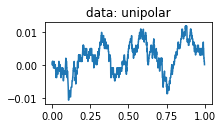

progressive accuracy=========>


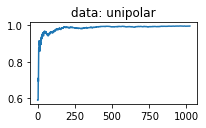

In [301]:
exp_comb_test(10,"unipolar", "Sobol")